# **Sector Rotation Strategy Analysis with OpenBB**

Sector rotation involves shifting investments across different sectors in the stock market, based on economic cycles or market performance expectations. This strategy seeks to maximize returns by focusing on sectors that are expected to perform better in the current market environment while reducing exposure to underperforming sectors.

Author:<br>
[Sanchit Mahajan](https://github.com/SanchitMahajan236)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LpAMLrbOB0YxWxoZfA5AvL2bTCoUdP6_?usp=sharing)

In [ ]:
!pip install openbb -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openbb import obb

In [18]:
sector_etfs = ['XLF', 'XLE', 'XLK', 'XLY', 'XLI', 'XLU', 'XLV']

start_date = '2015-01-01'
etf_dataframes = []

for etf in sector_etfs:
    try:
        data = obb.etf.historical(
            symbol=etf,
            start_date=start_date,
            provider="yfinance"
        ).to_df()
        data['Symbol'] = etf
        etf_dataframes.append(data)
    except Exception as e:
        print(f"Failed to fetch data for {etf}: {str(e)}")

combined_etf_data = pd.concat(etf_dataframes)
combined_etf_data = combined_etf_data.reset_index()

combined_etf_data.head()

,date,open,high,low,close,volume,split_ratio,dividend,capital_gains,Symbol
0,2015-01-02,20.194963,20.227457,19.935013,20.089357,40511471,0.0,0.0,0.0,XLF
1,2015-01-05,19.959383,20.000000,19.618196,19.666937,50770502,0.0,0.0,0.0,XLF
2,2015-01-06,19.666937,19.731924,19.277012,19.366369,57454463,0.0,0.0,0.0,XLF
3,2015-01-07,19.528837,19.618196,19.415110,19.569456,36287049,0.0,0.0,0.0,XLF
4,2015-01-08,19.796913,19.910643,19.756296,19.861900,37995923,0.0,0.0,0.0,XLF


In [20]:
combined_etf_data['date'] = pd.to_datetime(combined_etf_data['date'])
combined_etf_data = combined_etf_data[['date', 'close', 'Symbol']]

pivoted_data = combined_etf_data.pivot_table(index='date', columns='Symbol', values='close')

pivoted_data.ffill()

pivoted_data.head()

Symbol,XLE,XLF,XLI,XLK,XLU,XLV,XLY
date,,,,,,,
2015-01-02,79.529999,20.089357,56.509998,41.270000,47.439999,68.629997,71.629997
2015-01-05,76.239998,19.666937,55.189999,40.639999,46.860001,68.279999,70.260002
2015-01-06,75.120003,19.366369,54.509998,40.150002,46.889999,68.050003,69.559998
2015-01-07,75.279999,19.569456,54.919998,40.490002,47.349998,69.650002,70.660004
2015-01-08,76.970001,19.861900,56.020000,41.380001,47.680000,70.839996,71.720001


In [21]:
def sector_rotation_strategy(etf_data, lookback_period=3, top_n=3):
    """
    Implements a simple sector rotation strategy that invests in the top 'n' sector ETFs based on
    past performance over a lookback period.

    Parameters:
    etf_data (DataFrame): ETF performance data
    lookback_period (int): Number of months to look back for performance evaluation
    top_n (int): Number of top sector ETFs to invest in

    Returns:
    DataFrame: Portfolio returns based on the sector rotation strategy
    """
    monthly_returns = etf_data.resample('ME').last().pct_change()

    portfolio_returns = pd.DataFrame(index=monthly_returns.index, columns=['Portfolio Return'])

    for date in monthly_returns.index[lookback_period:]:
        past_returns = monthly_returns.loc[date - pd.DateOffset(months=lookback_period):date].mean()
        top_etfs = past_returns.nlargest(top_n).index

        next_month_date = date + pd.DateOffset(months=1)

        if next_month_date in monthly_returns.index:
            next_month_return = monthly_returns.loc[next_month_date, top_etfs].mean()
            portfolio_returns.loc[next_month_date, 'Portfolio Return'] = next_month_return

    return portfolio_returns

portfolio_returns = sector_rotation_strategy(pivoted_data, lookback_period=3, top_n=3)
portfolio_returns.dropna(inplace=True)

portfolio_returns.head()

,Portfolio Return
date,
2015-06-30,-0.016801
2015-08-31,-0.071857
2015-09-30,-0.0343
2015-11-30,-0.005501
2016-01-31,-0.048637


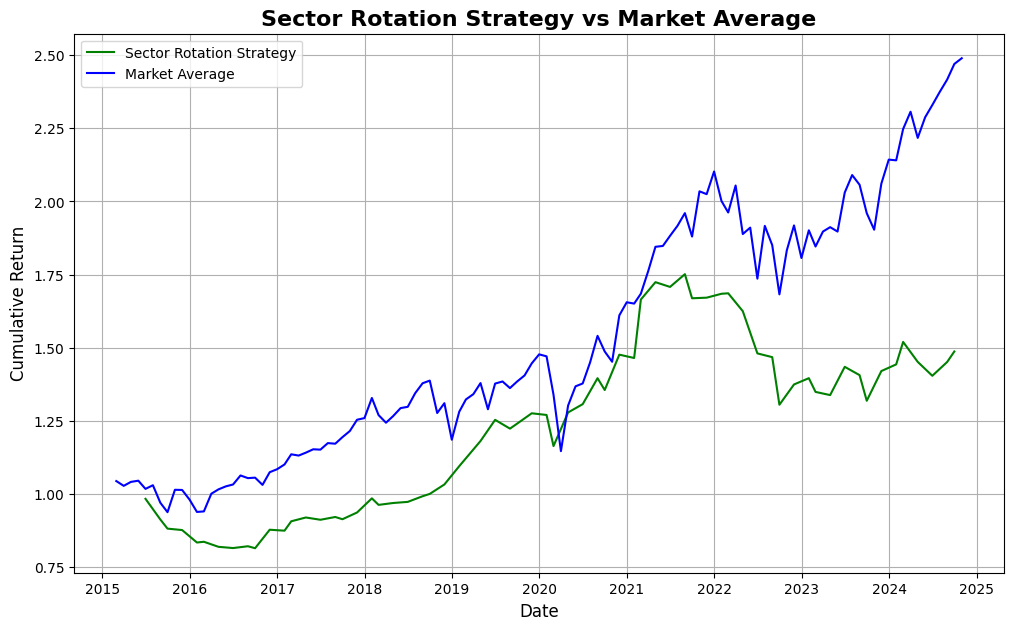

In [22]:
portfolio_returns['Cumulative Return'] = (1 + portfolio_returns['Portfolio Return']).cumprod()

pivoted_data['Market Average'] = pivoted_data.mean(axis=1)
market_returns = pivoted_data['Market Average'].resample('ME').last().pct_change()
market_cumulative_return = (1 + market_returns).cumprod()

plt.figure(figsize=(12, 7))
plt.plot(portfolio_returns.index, portfolio_returns['Cumulative Return'], label='Sector Rotation Strategy', color='green')
plt.plot(market_cumulative_return.index, market_cumulative_return, label='Market Average', color='blue')

plt.title('Sector Rotation Strategy vs Market Average', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [23]:
final_strategy_return = portfolio_returns['Cumulative Return'].iloc[-1]

final_market_return = market_cumulative_return.iloc[-1]

print(f"Final cumulative return of sector rotation strategy: {final_strategy_return:.2f}")
print(f"Final cumulative return of market average: {final_market_return:.2f}")

strategy_daily_returns = portfolio_returns['Portfolio Return'].dropna()
sharpe_ratio = (strategy_daily_returns.mean() / strategy_daily_returns.std()) * np.sqrt(12)
print(f"Sharpe Ratio of the sector rotation strategy: {sharpe_ratio:.2f}")

Final cumulative return of sector rotation strategy: 1.49
Final cumulative return of market average: 2.49
Sharpe Ratio of the sector rotation strategy: 0.54
